# Sentiment Analysis y Algorithmic Trading (Basico)

### Se debe ampliar el lexicon para mejorar la clasificación del sentimiento de noticias

In [1]:
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pandas.tseries.offsets import BDay
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import timedelta
import matplotlib.ticker as ticker

In [2]:
#Usamos Pandas_Datareader para descargar data
stock = 'TSLA'
start = dt.datetime(2018, 1, 1)

data = web.get_data_yahoo(stock, start)

In [3]:
#Creamos una estrategia simple: Para este ejemplo sera 10 y 20 MA
data['10_MA'] = data['Adj Close'].rolling(10).mean()
data['20_MA'] = data['Adj Close'].rolling(20).mean()
data.dropna(inplace = True)
data.head()

,High,Low,Open,Close,Volume,Adj Close,10_MA,20_MA
Date,,,,,,,,
2018-01-30,69.653999,68.433998,69.028000,69.164001,23588500.0,69.164001,69.356599,67.559400
2018-01-31,71.237999,69.038002,69.501999,70.862000,31070500.0,70.862000,69.499599,67.897200
2018-02-01,71.931999,69.725998,70.199997,69.849998,20988500.0,69.849998,69.593199,68.217200
2018-02-02,70.389999,68.101997,69.688004,68.750000,18524000.0,68.750000,69.467799,68.508500
2018-02-05,68.893997,66.599998,67.594002,66.625999,22320500.0,66.625999,69.099200,68.673999


In [4]:
#SMA Trade Calls
Trade_Buy = []
Trade_Sell = []

for i in range(len(data) - 1):
    if ((data['10_MA'].values[i] < data['20_MA'].values[i]) & (data['10_MA'].values[i+1] > data['20_MA'].values[i+1])):
        print(f'Trade Call para la fila {i} es Buy')
        Trade_Buy.append(i)
    elif ((data['10_MA'].values[i] > data['20_MA'].values[i]) & (data['10_MA'].values[i+1] < data['20_MA'].values[i+1])):
        print(f'Trade Call para la fila {i} es Sell')
        Trade_Sell.append(i)

Trade Call para la fila 5 es Sell
Trade Call para la fila 18 es Buy
Trade Call para la fila 28 es Sell
Trade Call para la fila 51 es Buy
Trade Call para la fila 60 es Sell
Trade Call para la fila 67 es Buy
Trade Call para la fila 77 es Sell
Trade Call para la fila 88 es Buy
Trade Call para la fila 106 es Sell
Trade Call para la fila 130 es Buy
Trade Call para la fila 142 es Sell
Trade Call para la fila 164 es Buy
Trade Call para la fila 173 es Sell
Trade Call para la fila 186 es Buy
Trade Call para la fila 213 es Sell
Trade Call para la fila 214 es Buy
Trade Call para la fila 226 es Sell
Trade Call para la fila 239 es Buy
Trade Call para la fila 246 es Sell
Trade Call para la fila 259 es Buy
Trade Call para la fila 265 es Sell
Trade Call para la fila 297 es Buy
Trade Call para la fila 303 es Sell
Trade Call para la fila 343 es Buy
Trade Call para la fila 378 es Sell
Trade Call para la fila 403 es Buy
Trade Call para la fila 421 es Sell
Trade Call para la fila 426 es Buy
Trade Call para

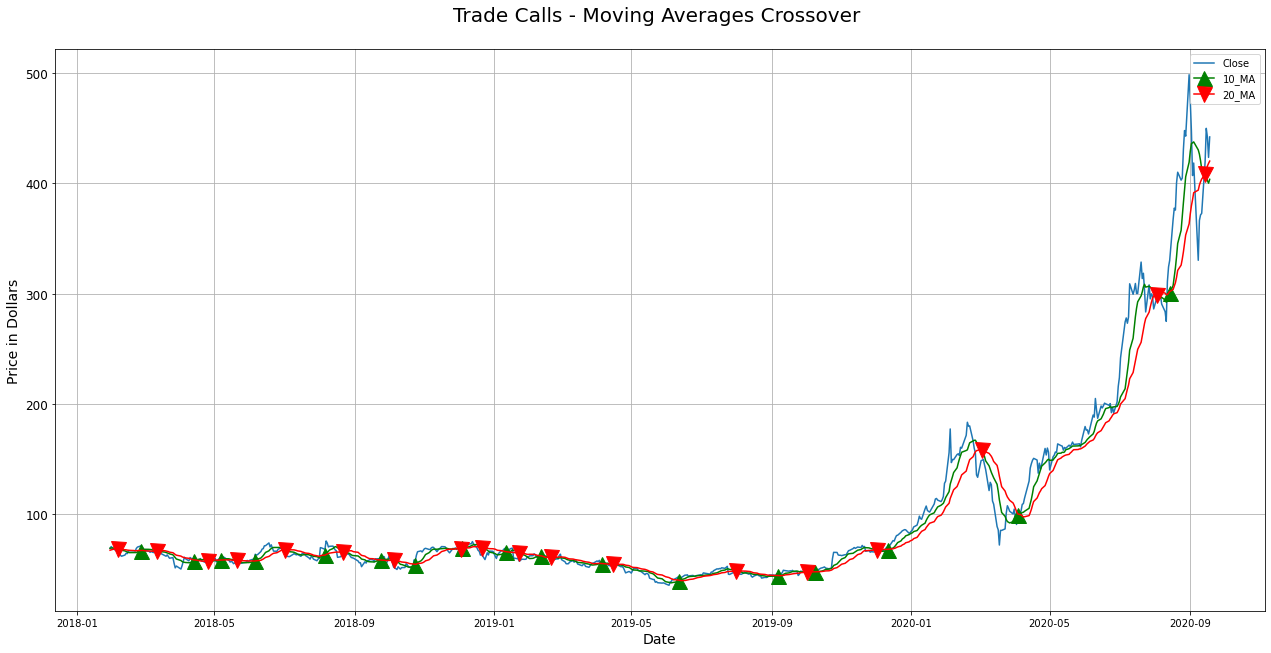

In [5]:
#Graficamos el algoritmo
plt.figure(figsize=(20, 10))
plt.plot(data.index, data['Adj Close'])
plt.plot(data.index, data['10_MA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(data.index, data['20_MA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.yticks(fontsize=12)
plt.title('Trade Calls - Moving Averages Crossover \n', fontdict = {'size': 20})
plt.legend(['Close','10_MA','20_MA'])
plt.subplots_adjust(top = 0.92, left = 0.09, right = 0.93, bottom = 0.14)
plt.grid()
plt.show() 

In [6]:
''' Vamos a utilizar el News API para descargar las noticias mas relevantes del stock '''

#El url de la pagina de News API
url = 'https://newsapi.org/v2/everything?'

parameters = {'q' : stock, #Stock para el Query
              'sortby' : 'popularity', #Los articulos de paginas mas populares
              'pageSize' : 100, #Lo maximo que se permite para Devs
              'language' : 'en', #Idioma
              'apiKey': 'YOUR-KEY' } #Key Personal

req = requests.get(url, params = parameters)
req_data = pd.DataFrame(req.json())

#Arreglamos la data
news_df = pd.concat([req_data['articles'].apply(pd.Series)], axis = 1)
final_news = news_df.loc[:, ['publishedAt', 'title']]
final_news['publishedAt'] = pd.to_datetime(final_news['publishedAt'])
final_news.sort_values(by = 'publishedAt', inplace = True)
final_news.head()

,publishedAt,title
28,2020-08-18 13:14:49+00:00,Tesla and Apple set stock splits to lower shar...
45,2020-08-18 14:50:57+00:00,"In One Chart: Bill Gates, Elon Musk, Jeff Bezo..."
20,2020-08-18 15:26:00+00:00,Here’s a Novel Explanation for Why Tesla Stock...
42,2020-08-18 16:41:16+00:00,The Technical Indicator: Charting a pulling-te...
82,2020-08-20 13:13:12+00:00,Tesla: The Most Dangerous Stock For Fiduciaries


In [7]:
#Creamos una funcion que diga que dia del headline debe ser usado como una opcion
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None

In [8]:
#Usamos la funcion
final_news['Trading_Time'] = final_news['publishedAt'].apply(get_trade_open)
final_news.dropna(inplace = True)
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['Trading_Time']).dt.date)

In [9]:
#Iniciamos un objeto vader
vader = SentimentIntensityAnalyzer()

In [10]:
#Calculamos los scores
scores = pd.DataFrame(final_news['title'].apply(vader.polarity_scores).tolist())
final_news['compound'] = scores['compound'].values.tolist()
final_news = final_news[final_news['compound'] != 0].reset_index(drop = True)
final_news.head()

,publishedAt,title,Trading_Time,Date,compound
0,2020-08-20 13:13:12+00:00,Tesla: The Most Dangerous Stock For Fiduciaries,2020-08-20 13:30:00+00:00,2020-08-20,-0.5256
1,2020-08-21 22:28:06+00:00,Tesla Shares Surge 49% Since Announcing Stock ...,2020-08-24 13:30:00+00:00,2020-08-24,0.2960
2,2020-08-24 02:19:36+00:00,Key Words: Market timing when ‘clocks have no ...,2020-08-24 13:30:00+00:00,2020-08-24,-0.5574
3,2020-08-24 13:27:05+00:00,Having It Both Ways: Investors Bid Up Stocks O...,2020-08-24 13:30:00+00:00,2020-08-24,0.5267
4,2020-08-25 13:24:31+00:00,Salesforce Gets Ready To Report Later After Be...,2020-08-25 13:30:00+00:00,2020-08-25,0.3612


In [11]:
''' Ampliamos el analisis al mayor score de cada dia '''
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data_group = grouped_dates.get_group(key)
    if data_group["compound"].max() > 0:
        max_cs.append(data_group["compound"].max())
    elif data_group["compound"].max() < 0:
        max_cs.append(0)
    
    if data_group["compound"].min() < 0:
        min_cs.append(data_group["compound"].min())
    elif data_group["compound"].min() > 0:
        min_cs.append(0)
    
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)
extreme_scores_df['Final Score'] = extreme_scores_df['max_scores'] + extreme_scores_df['min_scores']
extreme_scores_df.head()

,Date,max_scores,min_scores,Final Score
0,2020-08-20,0.0000,-0.5256,-0.5256
1,2020-08-24,0.5267,-0.5574,-0.0307
2,2020-08-25,0.3612,0.0000,0.3612
3,2020-08-27,0.0000,-0.5859,-0.5859
4,2020-08-31,0.7351,-0.4939,0.2412


In [12]:
''' Usamos el Compound Score de Vader para el algoritmo ''' 
Vader_Buy = []
Vader_Sell = []

for i in range(len(extreme_scores_df)):
    if extreme_scores_df['Final Score'].values[i] > 0.3: #Threshold Opcional
        print(f'Trade Call para fila {i} es Buy')
        Vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['Final Score'].values[i] < 0.3: #Threshold Opcional
        print(f'Trade Call para fila {i} es Sell')
        Vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

Trade Call para fila 0 es Sell
Trade Call para fila 1 es Sell
Trade Call para fila 2 es Buy
Trade Call para fila 3 es Sell
Trade Call para fila 4 es Sell
Trade Call para fila 5 es Buy
Trade Call para fila 6 es Sell
Trade Call para fila 7 es Sell
Trade Call para fila 8 es Sell
Trade Call para fila 9 es Sell
Trade Call para fila 10 es Sell
Trade Call para fila 11 es Sell
Trade Call para fila 12 es Buy
Trade Call para fila 13 es Sell
Trade Call para fila 14 es Buy
Trade Call para fila 15 es Buy
Trade Call para fila 16 es Buy
Trade Call para fila 17 es Sell


In [13]:
''' Por alguna razon, no reconoce la variable data despues de usarla...'''
stock = 'TSLA'
start = dt.datetime(2018, 1, 1)
data = web.get_data_yahoo(stock, start)
data['10_MA'] = data['Adj Close'].rolling(10).mean()
data['20_MA'] = data['Adj Close'].rolling(20).mean()
data.dropna(inplace = True)

In [14]:
''' Volvemos a iterar para quedarnos con las fechas que se crucen '''

vader_buy = []
for i in range(len(data)):
    if data.index[i].date() in Vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(data)):
    if data.index[i].date() in Vader_Sell:
        vader_sell.append(i)

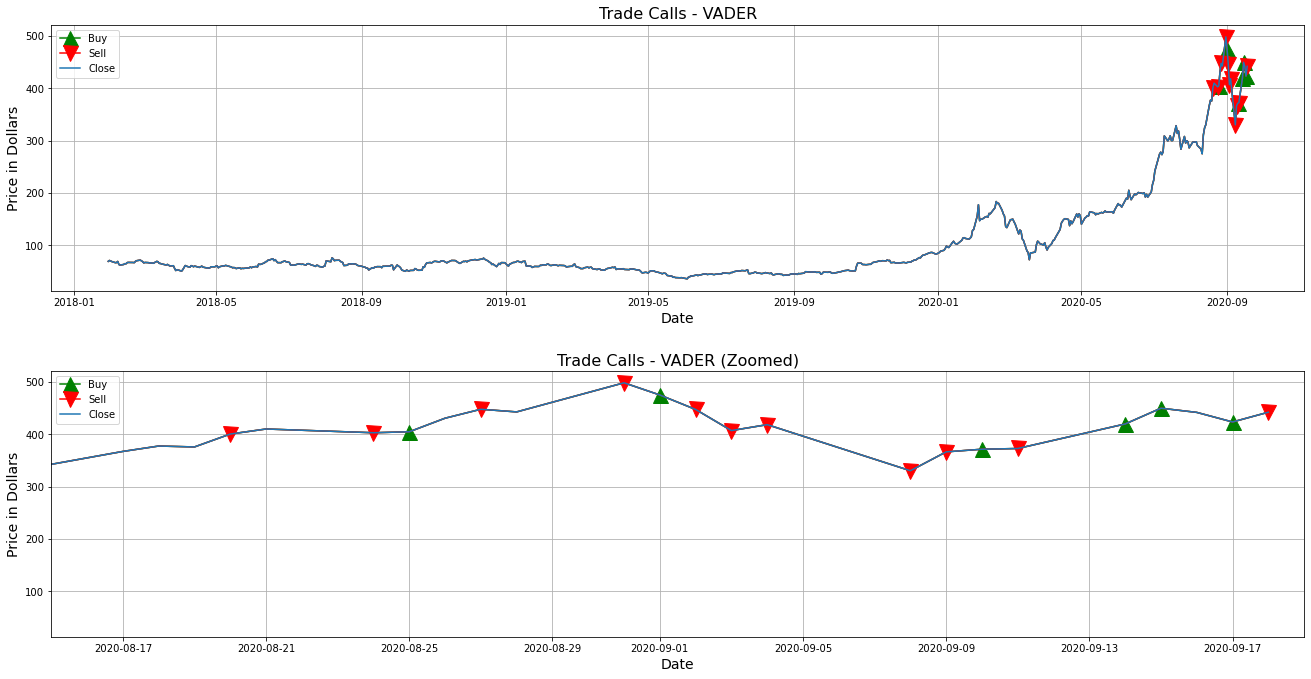

In [15]:
#Graficamos
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
ax[0].plot(data.index, data['Adj Close'],'-^', markevery=vader_buy, ms=15, color='green')
ax[0].plot(data.index, data['Adj Close'],'-v', markevery=vader_sell, ms=15, color='red')
ax[0].plot(data.index, data['Adj Close'])
ax[0].set_xlabel('Date',fontsize=14)
ax[0].set_ylabel('Price in Dollars', fontsize = 14)
ax[0].set_title('Trade Calls - VADER', fontsize = 16)
ax[0].legend(['Buy','Sell','Close'])
ax[0].grid()

ax[1].plot(data.index, data['Adj Close'],'-^', markevery=vader_buy, ms=15, color='green')
ax[1].plot(data.index, data['Adj Close'],'-v', markevery=vader_sell, ms=15, color='red')
ax[1].plot(data.index, data['Adj Close'])
ax[1].set_xlabel('Date',fontsize=14)
ax[1].set_ylabel('Price in Dollars', fontsize = 14)
ax[1].set_title('Trade Calls - VADER (Zoomed)', fontsize = 16)
ax[1].legend(['Buy','Sell','Close'])
ax[1].set_xlim(final_news.Date[0] - timedelta(5), data.index[-1] + timedelta(1))
ax[1].grid()

plt.subplots_adjust(top = 0.94, bottom = 0.09, right = 0.94, left = 0.07, hspace = 0.3)
plt.show() 

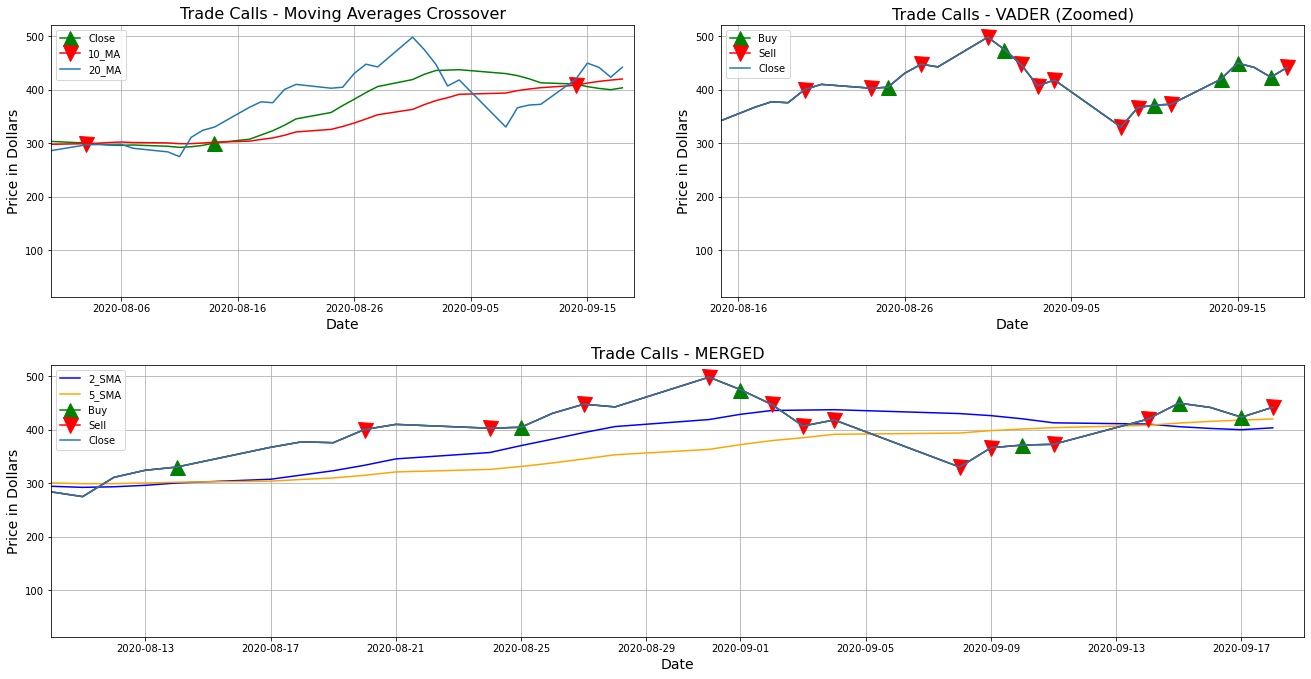

In [16]:
''' Un grafico con las estrategias individuales y combinadas '''
plt.figure(figsize = (20, 10))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan = 1, colspan = 1)
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan = 1, colspan = 1)
ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan = 1, colspan = 2)

ax1.plot(data.index, data['10_MA'],'-^', markevery=Trade_Buy, ms=15, color='green')
ax1.plot(data.index, data['20_MA'],'-v', markevery=Trade_Sell, ms=15, color='red')
ax1.plot(data.index, data['Adj Close'])
ax1.set_xlabel('Date',fontsize=14)
ax1.set_ylabel('Price in Dollars', fontsize = 14)
ax1.set_title('Trade Calls - Moving Averages Crossover', fontsize =  16)
ax1.set_xlim(final_news.Date[0] - timedelta(20), data.index[-1] + timedelta(1))
ax1.legend(['Close','10_MA','20_MA'])
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.grid()

ax2.plot(data.index, data['Adj Close'],'-^', markevery=vader_buy, ms=15, color='green')
ax2.plot(data.index, data['Adj Close'],'-v', markevery=vader_sell, ms=15, color='red')
ax2.plot(data.index, data['Adj Close'])
ax2.set_xlabel('Date',fontsize=14)
ax2.set_ylabel('Price in Dollars', fontsize = 14)
ax2.set_title('Trade Calls - VADER (Zoomed)', fontsize = 16)
ax2.legend(['Buy','Sell','Close'])
ax2.set_xlim(final_news.Date[0] - timedelta(5), data.index[-1] + timedelta(1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid()

#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

ax3.plot(data.index, data['10_MA'], color='blue')
ax3.plot(data.index, data['20_MA'], color='orange')
ax3.plot(data.index, data['Adj Close'],'-^', markevery=final_buy, ms=15, color='green')
ax3.plot(data.index, data['Adj Close'],'-v', markevery=final_sell, ms=15, color='red')
ax3.plot(data.index, data['Adj Close'])
ax3.set_xlabel('Date',fontsize=14)
ax3.set_ylabel('Price in Dollars', fontsize = 14)
ax3.set_title('Trade Calls - MERGED', fontsize = 16)
ax3.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
ax3.set_xlim(final_news.Date[0] - timedelta(10), data.index[-1] + timedelta(1))
ax3.grid()

plt.subplots_adjust(top = 0.94, bottom = 0.09, right = 0.94, left = 0.07, hspace = 0.25, wspace = 0.15)
plt.show() 

## Conclusiones

- El analisis de sentimientos encuentra mayores puntos de trading a diferencia del MA basico
- Si bien encuentra mas oportunidades de negociación, el el resulto no siempre es el esperado
- Es necesario aumentar el lexicon de Vader con palabras financieras para una mayor identificación de los sentimientos
- Es importante el uso de Backtest para cada algoritmo que se quiera realizar